# Universal sentence encoder

The structure of this notebook is similar to the structure of BERT notebook. First we preprocess the data, compute the embeddings, and compute the similarities.

Note: if you installed the environment from environment.yml, you might need to additionally install *tensorflow_hub* using `pip install tensorflow_hub` if you wish to compute the embeddings manually.

In [1]:
import tensorflow as tf
import numpy as np
import os, sys
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [2]:
# get cosine similairty matrix
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity

# get topN similar sentences
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]

In [3]:
import pandas as pd
data = pd.read_csv("dataset/data.csv", sep = ";")

In [4]:
def preprocess(A, labels):
    B = []
    labels_new = []
    for i in range(len(A)):

        text = A[i]
        # remove old style retweet text "RT"
        text = re.sub(r'^RT[\s]+', '', text)

        # remove hyperlinks
        text= re.sub(r'https?:\/\/.*[\r\n]*', '', text)

        # remove hashtags
        # only removing the hash # sign from the word
        text = re.sub(r'#', '', text)

        # remove tagging @
        text = re.sub(r"(?:\@|https?\://)\S+", "", text)

        # remove new line \n
        text = re.sub("\n", "", text)
        
        # remove numbers
        text = text.replace("[0-9]", " ")
    
        # to lower case
        text = text.lower()

        # remove zero length tweets
        if(len(text) == 0 ):
            continue

        B.append(text)
        labels_new.append(labels[i])
    return B, labels_new

In [5]:
import re
texts, labels = preprocess(data["text"], data["label"])
len(texts)

54395

In [6]:
#ids = np.random.choice(list(range(len(texts))), size = 57581)
ids = np.arange(0, len(texts))
ids = np.sort(ids)
l = np.array(labels)[ids]
t = np.array(texts)[ids]
ids = np.argsort(l)
l = l[ids]
t = t[ids].tolist()
l

array(['abusive', 'abusive', 'abusive', ..., 'toxic', 'toxic', 'toxic'],
      dtype='<U12')

The next part of code imports the model and computes the embeddings. However, the computation might take a while, so we suggest you to just skip to the **Import embeddings** subsection.

In [6]:
import tensorflow_hub as hub
import spacy_universal_sentence_encoder
nlp = spacy_universal_sentence_encoder.load_model('en_use_lg')

In [36]:
# get two documents
docs = list(nlp.pipe(t))

In [37]:
embeddings = [doc.vector for doc in docs]

In [39]:
test = np.array(embeddings)
test.shape

np.savez_compressed("use_embeddings", embeddings = test)

## Import embeddings
If you wish to run the code without computing the embeddings yourself in the above cells, we provide you with the embeddings. You can download them [here](https://drive.google.com/file/d/1X07gTzFjmrTjguavJFqvd9BrlHi9WxWZ/view?usp=sharing) and put them in the *code* directory.

In [7]:
test = np.load("use_embeddings.npz")
test = test["embeddings"]
print(test)

[[-0.0248306  -0.02076823 -0.03432957 ... -0.03455509 -0.02371345
   0.00155978]
 [ 0.0182208  -0.00293666  0.03795592 ... -0.03999928 -0.02096456
   0.02646431]
 [-0.05966632  0.07056623 -0.07427562 ...  0.04290533  0.00909936
   0.01480398]
 ...
 [-0.00337342 -0.04251742  0.00702513 ... -0.05049346  0.03261129
   0.05024904]
 [ 0.05360725 -0.05981196  0.06131688 ... -0.08435661 -0.03101975
   0.02740242]
 [-0.01446245  0.04500685  0.06157331 ...  0.01559918  0.04664094
  -0.02969109]]


In [8]:
# sort
idx = np.argsort(labels)
labels = np.array(labels)[idx]
test = test[idx, :]

In [9]:
simmat = cosine_similarity(test, test)
simmat.shape

(54395, 54395)

In [10]:
labs, occ = np.unique(labels, return_counts = True)
indices = np.cumsum(occ)
indices = np.insert(indices, 0, 0)
indices

array([    0,  4219,  6558,  6816,  8080,  9829, 11233, 19105, 27549,
       28069, 28826, 28966, 32507, 40231, 40709, 54395], dtype=int64)

In [11]:
avgs = []
for i in range(len(indices) - 1):
    avgs.append(np.mean(test[indices[i]:indices[i+1], :], axis = 0))
len(avgs)

15

In [12]:
simmat1 = cosine_similarity(avgs, avgs)
simmat1.shape

(15, 15)

In [13]:
df = pd.DataFrame(simmat1, columns = labs, index = labs)
df

,abusive,benevolent,cyberbulling,hate,hateful,identity,insult,obscene,offensive,profane,racism,sexism,spam,threat,toxic
abusive,1.000000,0.863759,0.852676,0.855484,0.987313,0.861411,0.857329,0.850673,0.855044,0.852152,0.850659,0.857641,0.947325,0.840473,0.926139
benevolent,0.863759,1.000000,0.989933,0.994255,0.881070,0.996347,0.995480,0.916780,0.991396,0.994001,0.987508,0.996458,0.888387,0.985130,0.906888
cyberbulling,0.852676,0.989933,1.000000,0.991853,0.873499,0.990486,0.988728,0.907281,0.989444,0.991800,0.976071,0.992833,0.887155,0.976175,0.901521
hate,0.855484,0.994255,0.991853,1.000000,0.878670,0.995477,0.994855,0.913362,0.994064,0.996145,0.978900,0.997970,0.892703,0.982915,0.902119
hateful,0.987313,0.881070,0.873499,0.878670,1.000000,0.882027,0.880864,0.868607,0.874452,0.873895,0.867714,0.879465,0.980319,0.865717,0.945227
identity,0.861411,0.996347,0.990486,0.995477,0.882027,1.000000,0.997182,0.919656,0.993448,0.994225,0.984148,0.997549,0.894298,0.985249,0.907653
insult,0.857329,0.995480,0.988728,0.994855,0.880864,0.997182,1.000000,0.925224,0.990602,0.992889,0.983184,0.996554,0.895401,0.991444,0.910905
obscene,0.850673,0.916780,0.907281,0.913362,0.868607,0.919656,0.925224,1.000000,0.909702,0.908277,0.905739,0.916271,0.882352,0.919300,0.937869
offensive,0.855044,0.991396,0.989444,0.994064,0.874452,0.993448,0.990602,0.909702,1.000000,0.993145,0.975646,0.994867,0.883584,0.975937,0.899114
profane,0.852152,0.994001,0.991800,0.996145,0.873895,0.994225,0.992889,0.908277,0.993145,1.000000,0.981207,0.996939,0.886115,0.981082,0.901041


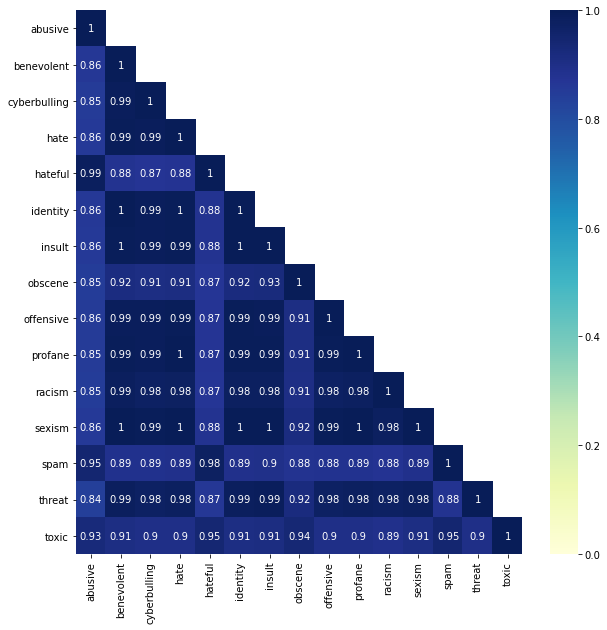

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
new_m = np.zeros((len(avgs), len(avgs)))
mask = np.triu(np.ones_like(new_m), k = 1)
sns.heatmap(df, cmap="YlGnBu", annot = True, mask = mask, ax = ax, vmin = 0, vmax = 1)
plt.show()